# Power-Law Model: Shear-Thinning Fluid Fitting

## What is This?

This notebook demonstrates the **Power-Law** (Ostwald–de Waele) model, the simplest and most widely used description of **non-Newtonian flow behavior**. The model assumes viscosity scales as a power of shear rate, providing excellent empirical fits for the **intermediate shear rate region** where most processing occurs.

**Why Power-Law?** It captures shear-thinning/thickening with only 2 parameters and enables analytical solutions for pipe flow, mixing, and coating processes.

## The Power-Law Model (Ostwald–de Waele)

**Constitutive Equations:**
$$\sigma(\dot{\gamma}) = K \dot{\gamma}^n$$

$$\eta(\dot{\gamma}) = K \dot{\gamma}^{n-1}$$

where:
- $K$ = consistency index (Pa·s$^n$) — sets viscosity magnitude at γ̇=1
- $n$ = flow behavior index (dimensionless) — controls shear-thinning/thickening

**Physical Meaning of n:**
- $n < 1$: **Shear-thinning** (pseudoplastic) — viscosity decreases with shear rate
  - Most polymer solutions, paints, ketchup, blood
  - Microstructure: polymer chain alignment, disentanglement, aggregate breakdown
- $n = 1$: **Newtonian** — constant viscosity (K = η)
  - Simple liquids, dilute solutions
- $n > 1$: **Shear-thickening** (dilatant) — viscosity increases with shear rate
  - Concentrated suspensions, cornstarch/water
  - Microstructure: hydrodynamic clustering, jamming

**Log-Log Linearity:**
$$\log(\eta) = \log(K) + (n-1)\log(\dot{\gamma})$$

Slope of log(η) vs log(γ̇) directly gives n-1.

> **Handbook:** See [Power-Law Model](../../docs/source/models/flow/power_law.rst) for pipe flow calculations (Buckingham equation), [Flow Models Overview](../../docs/source/models/flow/index.rst) for model hierarchy, and Bird et al. (1987) *Dynamics of Polymeric Liquids* for theoretical foundations.

## Learning Objectives

- Fit Power-Law model to viscosity data showing shear-thinning
- Understand flow behavior index (n) and consistency index (K)
- Interpret shear-thinning/thickening mechanisms
- Perform Bayesian inference for rheological parameters
- Apply to process design (pumping power, mixing)

**Prerequisites:** Basic rheology, complete 01-maxwell-fitting.ipynb

**Estimated Time:** 30-35 minutes

In [1]:
# Google Colab Setup - Run this cell first!
# Skip if running locally with rheojax already installed

import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # Install rheojax and dependencies
    !pip install -q rheojax
    
    # Colab uses float32 by default - we need float64 for numerical stability
    # This MUST be set before importing JAX
    import os
    os.environ['JAX_ENABLE_X64'] = 'true'
    
    print("✓ RheoJAX installed successfully!")
    print("✓ Float64 precision enabled")

## Setup

In [2]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
# Configure matplotlib for inline plotting in VS Code/Jupyter
# MUST come before importing matplotlib
%matplotlib inline

import time
import warnings

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.data import RheoData
from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models import PowerLaw
from rheojax.pipeline.base import Pipeline

jax, jnp = safe_import_jax()
verify_float64()
print("✓ JAX float64 enabled")

np.random.seed(42)
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

# Suppress matplotlib backend warning in VS Code
warnings.filterwarnings('ignore', message='.*non-interactive.*')

import os
import sys

sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"


✓ JAX float64 enabled


## Power-Law Theory

The Power-Law (Ostwald-de Waele) model describes non-Newtonian flow:

**Constitutive Equation:**
$$\eta(\dot{\gamma}) = K \dot{\gamma}^{n-1}$$
$$\sigma(\dot{\gamma}) = K \dot{\gamma}^n$$

**Parameters:**
- $K$ = consistency index (Pa·s$^n$) - magnitude of viscosity
- $n$ = flow behavior index:
  - $n < 1$: shear-thinning (most polymers)
  - $n = 1$: Newtonian (constant viscosity)
  - $n > 1$: shear-thickening (rare)

**Applications:** Polymer solutions, ketchup, paints, blood

In [3]:
# True parameters (shear-thinning)
K_true = 5.0   # Pa·s^n
n_true = 0.6   # Shear-thinning

print(f"True Parameters:")
print(f"  K = {K_true:.2f} Pa·s^{n_true}")
print(f"  n = {n_true:.2f} (shear-thinning)")

# Shear rate array
gamma_dot = np.logspace(-1, 3, 40)  # 0.1 to 1000 s⁻¹

# True viscosity
eta_true = K_true * gamma_dot**(n_true - 1)

# Add noise
noise_level = 0.02
noise = np.random.normal(0, noise_level * eta_true)
eta_noisy = eta_true + noise

print(f"\nData: {len(gamma_dot)} points")
print(f"Viscosity range: {eta_noisy.min():.3f} - {eta_noisy.max():.3f} Pa·s")

True Parameters:
  K = 5.00 Pa·s^0.6
  n = 0.60 (shear-thinning)

Data: 40 points
Viscosity range: 0.317 - 12.684 Pa·s


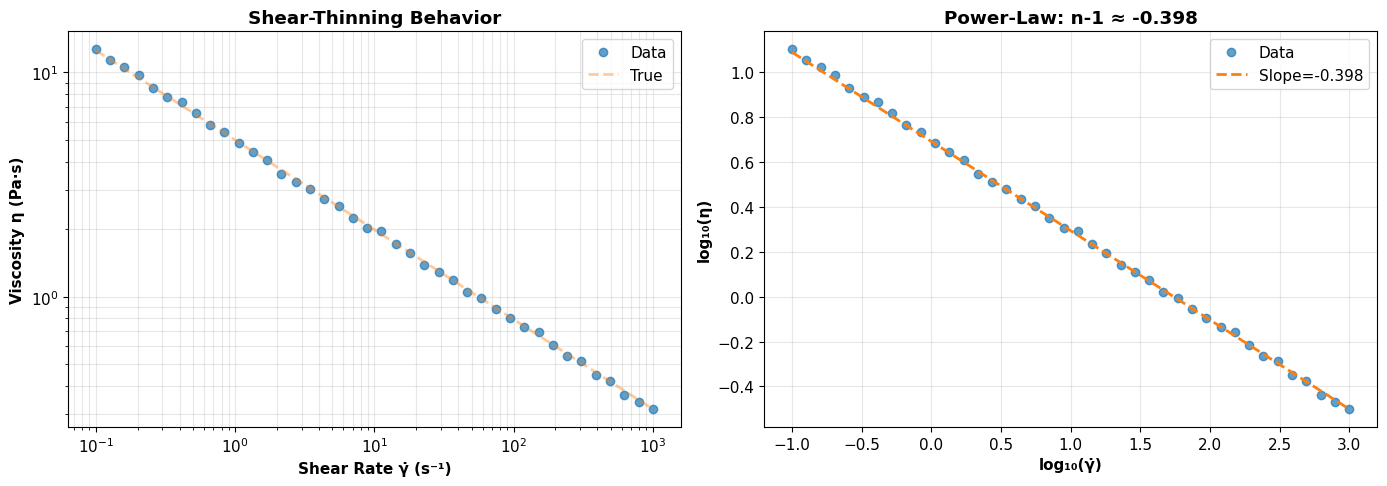


Estimated n from slope: 0.602 (true: 0.600)


In [4]:
# Visualize shear-thinning
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.loglog(gamma_dot, eta_noisy, 'o', alpha=0.7, label='Data')
ax1.loglog(gamma_dot, eta_true, '--', linewidth=2, alpha=0.4, label='True')
ax1.set_xlabel('Shear Rate γ̇ (s⁻¹)', fontweight='bold')
ax1.set_ylabel('Viscosity η (Pa·s)', fontweight='bold')
ax1.set_title('Shear-Thinning Behavior', fontweight='bold')
ax1.grid(True, alpha=0.3, which='both')
ax1.legend()

# Log-log slope = n-1
log_gd = np.log10(gamma_dot)
log_eta = np.log10(eta_noisy)
slope = np.polyfit(log_gd[10:30], log_eta[10:30], 1)[0]
ax2.plot(log_gd, log_eta, 'o', alpha=0.7, label='Data')
ax2.plot(log_gd, np.polyval([slope, np.polyfit(log_gd[10:30], log_eta[10:30], 1)[1]], log_gd), '--', linewidth=2, label=f'Slope={slope:.3f}')
ax2.set_xlabel('log₁₀(γ̇)', fontweight='bold')
ax2.set_ylabel('log₁₀(η)', fontweight='bold')
ax2.set_title(f'Power-Law: n-1 ≈ {slope:.3f}', fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
display(fig)
plt.close(fig)

print(f"\nEstimated n from slope: {slope+1:.3f} (true: {n_true:.3f})")


## Fitting (Log-Log Linear Regression)

In [5]:
model = PowerLaw()
model.fit(gamma_dot, eta_noisy)

K_fit = model.parameters.get_value('K')
n_fit = model.parameters.get_value('n')

print("="*60)
print("FITTED PARAMETERS")
print("="*60)
print(f"K = {K_fit:.3f} Pa·s^n (true: {K_true:.3f})")
print(f"n = {n_fit:.4f} (true: {n_true:.4f})")
print(f"\nErrors: K {abs(K_fit-K_true)/K_true*100:.2f}%, n {abs(n_fit-n_true)/n_true*100:.2f}%")
print(f"\nBehavior: {'Shear-thinning' if n_fit < 1 else 'Shear-thickening' if n_fit > 1 else 'Newtonian'}")
print("="*60)

FITTED PARAMETERS
K = 4.997 Pa·s^n (true: 5.000)
n = 0.5983 (true: 0.6000)

Errors: K 0.06%, n 0.29%

Behavior: Shear-thinning


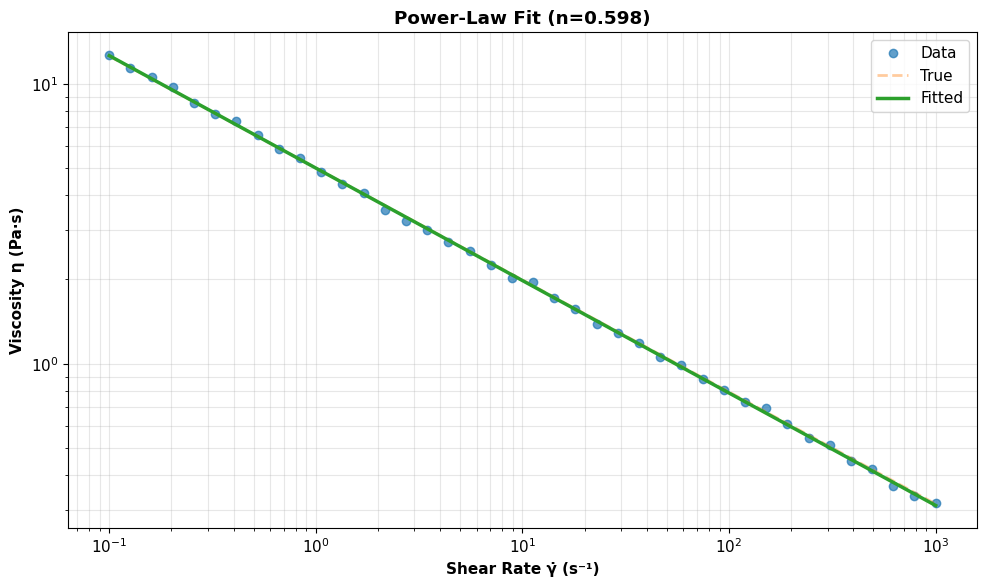

R² = 0.999544


In [6]:
# Visualize fit
eta_pred = model.predict(gamma_dot)

fig = plt.figure(figsize=(10, 6))
plt.loglog(gamma_dot, eta_noisy, 'o', alpha=0.7, label='Data')
plt.loglog(gamma_dot, eta_true, '--', linewidth=2, alpha=0.4, label='True')
plt.loglog(gamma_dot, eta_pred, '-', linewidth=2.5, label='Fitted')
plt.xlabel('Shear Rate γ̇ (s⁻¹)', fontweight='bold')
plt.ylabel('Viscosity η (Pa·s)', fontweight='bold')
plt.title(f'Power-Law Fit (n={n_fit:.3f})', fontweight='bold')
plt.grid(True, alpha=0.3, which='both')
plt.legend()
plt.tight_layout()
display(fig)
plt.close(fig)

r2 = 1 - np.sum((eta_noisy - eta_pred)**2) / np.sum((eta_noisy - np.mean(eta_noisy))**2)
print(f"R² = {r2:.6f}")


## Residual Analysis

Residual analysis is critical for Power-Law models: systematic curvature at low or high shear rates indicates the need for a bounded model (Carreau, Cross) that includes zero-shear and/or infinite-shear plateaus.

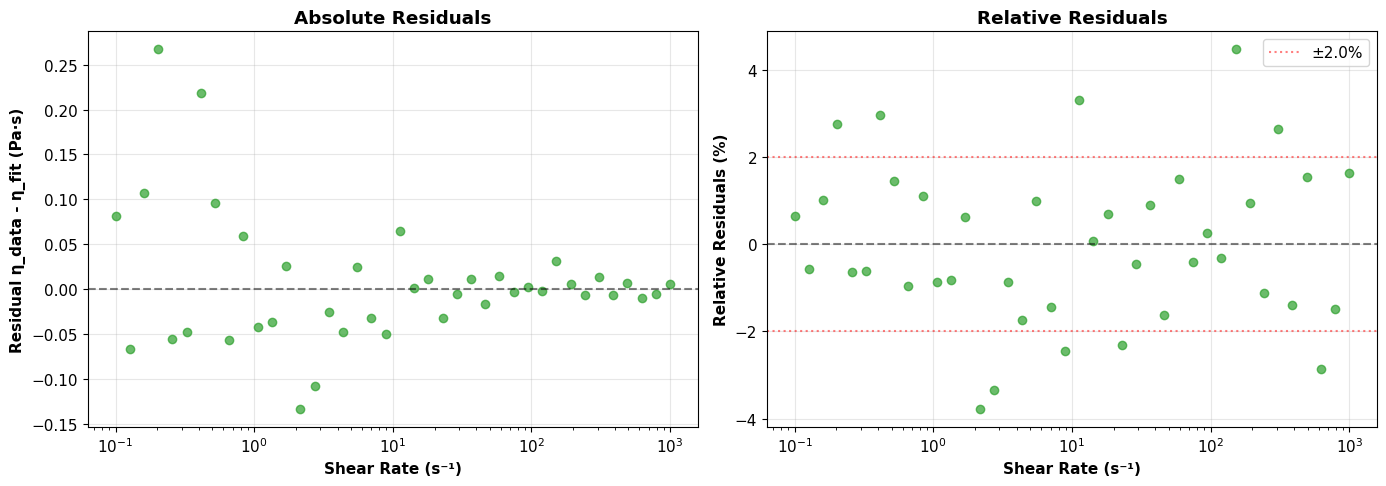

Mean |residual|: 1.49%
Max  |residual|: 4.46%

Note: If residuals curve upward at low γ̇, consider Carreau model (zero-shear plateau)


In [7]:
# Residual analysis
residuals = eta_noisy - eta_pred
relative_residuals = residuals / eta_noisy * 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Absolute residuals
ax1.semilogx(gamma_dot, residuals, 'o', alpha=0.7, color='#2ca02c')
ax1.axhline(0, color='black', linestyle='--', alpha=0.5)
ax1.set_xlabel('Shear Rate (s⁻¹)', fontweight='bold')
ax1.set_ylabel('Residual η_data - η_fit (Pa·s)', fontweight='bold')
ax1.set_title('Absolute Residuals', fontweight='bold')
ax1.grid(True, alpha=0.3)

# Relative residuals
ax2.semilogx(gamma_dot, relative_residuals, 'o', alpha=0.7, color='#2ca02c')
ax2.axhline(0, color='black', linestyle='--', alpha=0.5)
ax2.axhline(noise_level*100, color='red', linestyle=':', linewidth=1.5, alpha=0.5, label=f'±{noise_level*100:.1f}%')
ax2.axhline(-noise_level*100, color='red', linestyle=':', linewidth=1.5, alpha=0.5)
ax2.set_xlabel('Shear Rate (s⁻¹)', fontweight='bold')
ax2.set_ylabel('Relative Residuals (%)', fontweight='bold')
ax2.set_title('Relative Residuals', fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
display(fig)
plt.close(fig)

print(f"Mean |residual|: {np.mean(np.abs(relative_residuals)):.2f}%")
print(f"Max  |residual|: {np.max(np.abs(relative_residuals)):.2f}%")
print(f"\nNote: If residuals curve upward at low γ̇, consider Carreau model (zero-shear plateau)")

## Bayesian Inference

In [8]:
print("Running Bayesian inference...\n")

result = model.fit_bayesian(
    gamma_dot, eta_noisy,
    num_warmup=1000,
    num_samples=2000,
    num_chains=1,
    initial_values={'K': K_fit, 'n': n_fit}
)

print("Complete!")

Running Bayesian inference...



/Users/b80985/Projects/rheojax/rheojax/core/base.py:544: UserWarning: test_mode not specified. Defaulting to 'relaxation'. For correct posteriors, pass RheoData with metadata['test_mode'] or specify test_mode explicitly.
  result = super().fit_bayesian(


  0%|          | 0/3000 [00:00<?, ?it/s]

warmup:   0%|          | 1/3000 [00:00<27:34,  1.81it/s, 1 steps of size 1.65e+00. acc. prob=0.00]

warmup:  14%|█▍        | 415/3000 [00:00<00:03, 852.66it/s, 31 steps of size 1.22e-01. acc. prob=0.97]

warmup:  33%|███▎      | 991/3000 [00:00<00:01, 1966.18it/s, 19 steps of size 1.97e-01. acc. prob=0.98]

sample:  52%|█████▏    | 1573/3000 [00:00<00:00, 2909.03it/s, 15 steps of size 1.57e-01. acc. prob=0.99]

sample:  71%|███████   | 2136/3000 [00:00<00:00, 3612.69it/s, 15 steps of size 1.57e-01. acc. prob=0.99]

sample:  90%|█████████ | 2705/3000 [00:01<00:00, 4172.46it/s, 23 steps of size 1.57e-01. acc. prob=0.99]

sample: 100%|██████████| 3000/3000 [00:01<00:00, 2715.21it/s, 23 steps of size 1.57e-01. acc. prob=0.99]

Complete!


In [9]:
summary = result.summary
diagnostics = result.diagnostics
credible = model.get_credible_intervals(result.posterior_samples, 0.95)

print("="*60)
print("POSTERIOR SUMMARY")
print("="*60)
print(f"\nK = {summary['K']['mean']:.3f} ± {summary['K']['std']:.3f} Pa·s^n")
print(f"n = {summary['n']['mean']:.4f} ± {summary['n']['std']:.4f}")
print(f"\n95% CI K: [{credible['K'][0]:.3f}, {credible['K'][1]:.3f}]")
print(f"95% CI n: [{credible['n'][0]:.4f}, {credible['n'][1]:.4f}]")
print(f"\nR-hat: K={diagnostics['r_hat']['K']:.4f}, n={diagnostics['r_hat']['n']:.4f}")
print(f"ESS: K={diagnostics['ess']['K']:.0f}, n={diagnostics['ess']['n']:.0f}")
print("="*60)

# Check if credible interval confirms shear-thinning
if credible['n'][1] < 1:
    print("\n✓ Shear-thinning confirmed (95% CI n < 1)")
elif credible['n'][0] > 1:
    print("\n✓ Shear-thickening confirmed (95% CI n > 1)")
else:
    print("\n⚠ Behavior uncertain (95% CI includes n=1)")

POSTERIOR SUMMARY

K = 5.003 ± 0.017 Pa·s^n
n = 0.5955 ± 0.0020

95% CI K: [4.971, 5.038]
95% CI n: [0.5919, 0.5995]

R-hat: K=1.0006, n=1.0036
ESS: K=923, n=826

✓ Shear-thinning confirmed (95% CI n < 1)


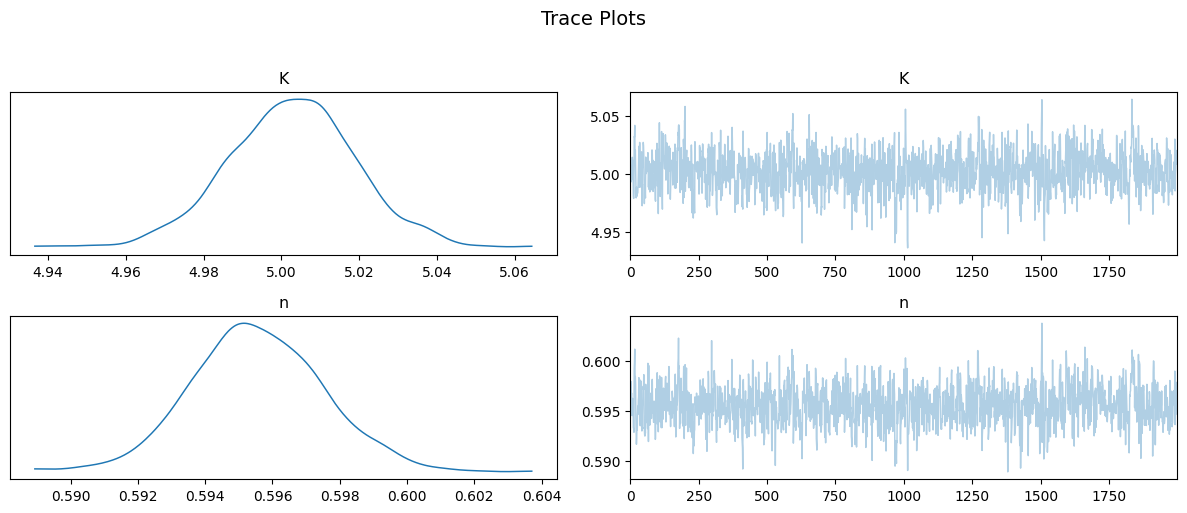

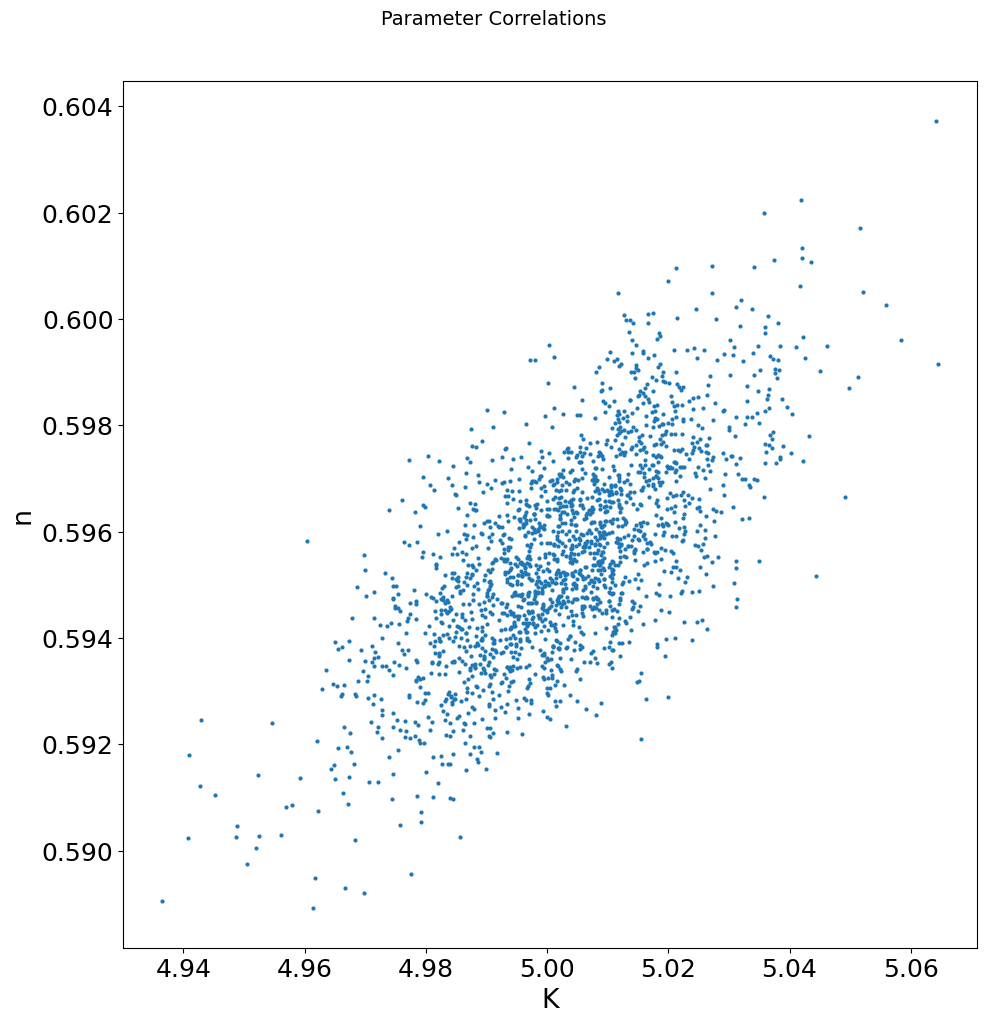

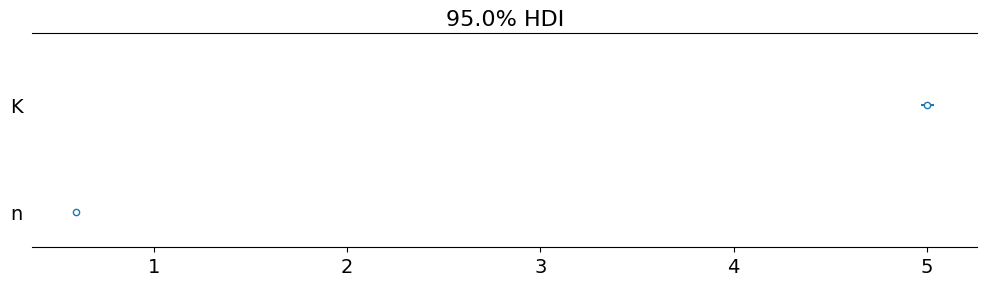

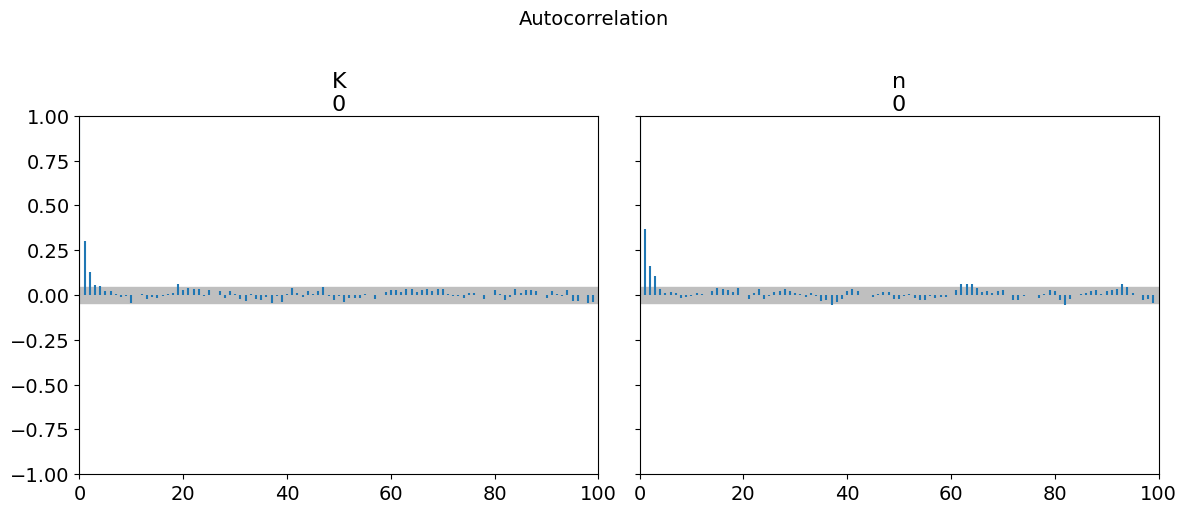

In [10]:
# ArviZ diagnostic plots (trace, pair, forest, energy, autocorr, rank)
display_arviz_diagnostics(result, ['K', 'n'], fast_mode=FAST_MODE)

### Convergence Diagnostic Interpretation

| Metric | Target | Meaning |
|--------|--------|---------|
| **R-hat < 1.01** | Chains converged | Multiple chains agree on posterior |
| **ESS > 400** | Sufficient samples | Independent information content |
| **Divergences < 1%** | Well-behaved sampler | No numerical issues in posterior geometry |

**For Power-Law models:** The n posterior is the key result — if the 95% credible interval lies entirely below 1.0, you have **statistically confirmed shear-thinning**. The width of the K posterior determines the precision of viscosity predictions at a reference shear rate.

## Key Takeaways

### Main Concepts

1. **Flow Behavior Index (n):**
   - n < 1: Viscosity decreases with shear rate (shear-thinning)
   - Most polymer solutions are shear-thinning (0.2 < n < 0.8)
   - Lower n → stronger thinning (more non-Newtonian)
   - Typical values: paints 0.4-0.6, polymer melts 0.3-0.7, ketchup 0.2-0.5

2. **Consistency Index (K):**
   - Sets overall viscosity magnitude
   - Temperature dependent: K(T) = K₀·exp(E_a/RT)
   - Use for batch-to-batch quality control
   - Higher K → "thicker" material at all shear rates

3. **Limited Validity:**
   - No zero-shear plateau (η₀) or infinite-shear plateau (η_∞)
   - Valid only in mid-range shear rates (typically 1-1000 s⁻¹)
   - Predicts η → ∞ as γ̇ → 0 (unphysical for real fluids)
   - Use Carreau or Cross for full flow curve

4. **Process Implications:**
   - Shear-thinning reduces pumping power vs Newtonian
   - Power saving scales as (3n+1)/(4n) relative to Newtonian
   - Pressure drop: ΔP ∝ Q^n (non-linear flow rate dependence)

### When to Use Power-Law Model

**Appropriate for:**
- ✓ Linear log-log flow curves (mid-range shear rates)
- ✓ Polymer melts, solutions, paints, sauces
- ✓ Quick process calculations (pipe flow, mixing)
- ✓ Empirical fitting for quality control
- ✓ Limited shear rate range (1-2 decades)

**Consider alternatives for:**
- ✗ Zero-shear plateau visible → Carreau, Cross
- ✗ Infinite-shear plateau visible → Carreau-Yasuda
- ✗ Yield stress (σ intercept) → Herschel-Bulkley
- ✗ Full flow curve needed → Carreau (4 parameters)

### Common Pitfalls

1. **Extrapolation Danger:**
   - Power-Law predicts unphysical behavior at extremes
   - Never extrapolate beyond fitted shear rate range
   - Use bounded models (Carreau) for wide range predictions

2. **Temperature Sensitivity:**
   - K changes dramatically with temperature (10°C → 50% change typical)
   - Always specify temperature with K value
   - Use Arrhenius analysis for temperature dependence

3. **Shear-Thickening Misidentification:**
   - n > 1 rare in real materials (except dense suspensions)
   - Check for inertial artifacts (Taylor vortices) at high γ̇
   - Verify with multiple geometries if n > 1.2

## Further Reading

### Related Models
- [**Power-Law Handbook**](../../docs/source/models/flow/power_law.rst) — Pipe flow calculations, temperature dependence, process optimization, and molecular weight estimation
- [**Carreau Model**](../../docs/source/models/flow/carreau.rst) — Adds zero-shear plateau (4 parameters)
- [**Herschel-Bulkley**](../../docs/source/models/flow/herschel_bulkley.rst) — Power-Law with yield stress (σ = σ_y + K·γ̇^n)
- [**Flow Models Overview**](../../docs/source/models/flow/index.rst) — Complete decision tree for model selection

### Key References
- **Ostwald, W. (1925)**. "Über die Geschwindigkeitsfunktion der Viskosität disperser Systeme." *Kolloid-Z.*, 36, 99–117. — Original power-law formulation
- **Bird, R.B., Armstrong, R.C., & Hassager, O. (1987)**. *Dynamics of Polymeric Liquids, Vol. 1*. 2nd ed., Wiley. — Canonical reference for non-Newtonian fluid mechanics
- **Macosko, C.W. (1994)**. *Rheology: Principles, Measurements, and Applications*. Wiley-VCH. — Practical guide with process applications
- **Chhabra, R.P. & Richardson, J.F. (2008)**. *Non-Newtonian Flow and Applied Rheology*. 2nd ed., Butterworth-Heinemann. — Engineering applications

### Advanced Workflows
- [**Mastercurve Generation**](../transforms/02-mastercurve-generation.ipynb) — Time-temperature superposition to extend shear rate range
- [**SRFS Transform**](../../docs/source/transforms/srfs.rst) — Strain-rate frequency superposition for flow curves
- [**Flow Model Comparison**](../advanced/02-flow-model-comparison.ipynb) — Compare Power-Law vs Carreau vs Cross

## Next Steps

**Explore Full Flow Curve Models:**
- [**Carreau Model**](../../docs/source/models/flow/carreau.rst) — Zero-shear and infinite-shear plateaus
- [**Cross Model**](../../docs/source/models/flow/cross.rst) — Alternative transition function
- [**Carreau-Yasuda**](../../docs/source/models/flow/carreau_yasuda.rst) — Adjustable transition sharpness

**Combine with Viscoelasticity:**
- [**Giesekus Model**](../../docs/source/models/giesekus/index.rst) — Shear-thinning + normal stresses
- [**PTT Model**](../../docs/source/models/ptt/index.rst) — Polymer processing applications

**Quality Control Applications:**
- Track K and n batch-to-batch for consistency
- Use 95% credible intervals from Bayesian inference as specification limits

In [11]:
import sys

import rheojax

print(f"Python: {sys.version}")
print(f"RheoJAX: {rheojax.__version__}")

Python: 3.13.9 (main, Oct 14 2025, 21:10:40) [Clang 20.1.4 ]
RheoJAX: 0.6.0
